# Import libraries

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define components of CycleGAN

## Residual block

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # padding, keep the image size constant after next conv2d
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )
    
    def forward(self, x):
        return x + self.block(x)

## Generator

In [3]:
class Generator(nn.Module):
    def __init__(self, in_channels, num_residual_blocks=9):
        super(Generator, self).__init__()
        # Encoder
        # Inital Convolution  3*256*256 -> 64*256*256
        out_channels=64
        self.conv = nn.Sequential(
            nn.ReflectionPad2d(in_channels), # padding, keep the image size constant after next conv2d
            nn.Conv2d(in_channels, out_channels, 2*in_channels+1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        
        channels = out_channels
        
        # Downsampling   64*256*256 -> 128*128*128 -> 256*64*64
        self.down = []
        for _ in range(2):
            out_channels = channels * 2
            self.down += [
                nn.Conv2d(channels, out_channels, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            channels = out_channels
        self.down = nn.Sequential(*self.down)
        
        # Transformer (ResNet-9 blocks)  256*64*64
        self.trans = [ResidualBlock(channels) for _ in range(num_residual_blocks)]
        self.trans = nn.Sequential(*self.trans)
        
        # Upsampling  256*64*64 -> 128*128*128 -> 64*256*256
        self.up = []
        for _ in range(2):
            out_channels = channels // 2
            self.up += [
                nn.Upsample(scale_factor=2), # bilinear interpolation
                nn.Conv2d(channels, out_channels, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            channels = out_channels
        self.up = nn.Sequential(*self.up)
        
        # Out layer  64*256*256 -> 3*256*256
        self.out = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(channels, in_channels, 2*in_channels+1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = self.down(x)
        x = self.trans(x)
        x = self.up(x)
        x = self.out(x)
        return x

## Discriminator

In [4]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            *self.block(in_channels, 64, normalize=False), # 3*256*256 -> 64*128*128 
            *self.block(64, 128),  # 64*128*128 -> 128*64*64
            *self.block(128, 256), # 128*64*64 -> 256*32*32
            *self.block(256, 512), # 256*32*32 -> 512*16*16
            
            nn.ZeroPad2d((1,0,1,0)), # padding left and top   512*16*16 -> 512*17*17
            nn.Conv2d(512, 1, 4, padding=1), # 512*17*17 -> 1*16*16
            # nn.Sigmoid()
        )
        
        self.scale_factor = 16
    
    @staticmethod
    def block(in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return layers
        
    def forward(self, x):
        return self.model(x)

## Losses

In [5]:
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

## Initialize generator and discriminator

In [6]:
G_AB = Generator(3, num_residual_blocks=9)
D_B = Discriminator(3)

G_BA = Generator(3, num_residual_blocks=9)
D_A = Discriminator(3)

In [7]:
cuda = torch.cuda.is_available()
print(f'cuda: {cuda}')
if cuda:
    G_AB = G_AB.cuda()
    D_B = D_B.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

cuda: True


## Optimizers

In [8]:
import itertools
lr = 0.0002
b1 = 0.5
b2 = 0.996

optimizer_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2))

optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(b1, b2))

optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2))

In [9]:
n_epoches = 200
decay_epoch = 100

lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(n_epoches-decay_epoch)

# Learning rate update schedulers
lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(n_epoches-decay_epoch)

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_func)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda_func)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda_func)

## Buffers of previously generated samples

In [10]:
import random
from torch.autograd import Variable

class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

In [11]:
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Datasets

In [47]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, data_dir, mode='train', transforms=None):
        A_dir = os.path.join(data_dir, 'A')
        B_dir = os.path.join(data_dir, 'B')
        
        if mode == 'train':
            self.files_A = [os.path.join(A_dir, name) for name in sorted(os.listdir(A_dir))[:250]]
            self.files_B = [os.path.join(B_dir, name) for name in sorted(os.listdir(B_dir))[:250]]
        elif mode == 'test':
            self.files_A = [os.path.join(A_dir, name) for name in sorted(os.listdir(A_dir))[250:]]
            self.files_B = [os.path.join(B_dir, name) for name in sorted(os.listdir(B_dir))[250:301]]
        
        self.transforms = transforms
        
    def __len__(self):
        return len(self.files_A)
    
    def __getitem__(self, index):
        file_A = self.files_A[index]
        file_B = self.files_B[index]
        
        img_A = Image.open(file_A)
        img_B = Image.open(file_B)
        
        if self.transforms is not None:
            img_A = self.transforms(img_A)
            img_B = self.transforms(img_B)
        
        return img_A, img_B

In [48]:
import torchvision.transforms as transforms

data_dir = '/kaggle/input/cycleganisfid/data/'

# Image transformations
transforms_ = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 5
# Training data loader
trainloader = DataLoader(
    ImageDataset(data_dir, mode='train', transforms=transforms_),
    batch_size = batch_size,
    shuffle = True,
    num_workers = 3
)
# Test data loader
testloader = DataLoader(
    ImageDataset(data_dir, mode='test', transforms=transforms_),
    batch_size = batch_size,
    shuffle = False,
    num_workers = 3
)

## Sample images

In [49]:
from torchvision.utils import make_grid

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

def sample_images(real_A, real_B, figside=1.5):
    assert real_A.size() == real_B.size(), 'The image size for two domains must be the same'
    
    G_AB.eval()
    G_BA.eval()
    
    real_A = real_A.type(Tensor)
    fake_B = G_AB(real_A).detach()
    real_B = real_B.type(Tensor)
    fake_A = G_BA(real_B).detach()
    
    nrows = real_A.size(0)
    real_A = make_grid(real_A, nrow=nrows, normalize=True)
    fake_B = make_grid(fake_B, nrow=nrows, normalize=True)
    real_B = make_grid(real_B, nrow=nrows, normalize=True)
    fake_A = make_grid(fake_A, nrow=nrows, normalize=True)
    
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1).cpu().permute(1, 2, 0)
    
    plt.figure(figsize=(figside*nrows, figside*4))
    plt.imshow(image_grid)
    plt.axis('off')
    plt.show()
    

In [50]:
real_A, real_B = next(iter(testloader))
sample_images(real_A, real_B)

StopIteration: 

# Training

----------------
[Epoch 1/200: G loss: 4.005330562591553 | D loss: 0.31435728073120117]
----------------
[Epoch 2/200: G loss: 3.8166050910949707 | D loss: 0.17001208662986755]
----------------
[Epoch 3/200: G loss: 3.7330422401428223 | D loss: 0.12707720696926117]
----------------
[Epoch 4/200: G loss: 2.7217907905578613 | D loss: 0.16672667860984802]
----------------
[Epoch 5/200: G loss: 2.9523749351501465 | D loss: 0.11973463743925095]
----------------
[Epoch 6/200: G loss: 3.1919593811035156 | D loss: 0.1411128044128418]
----------------
[Epoch 7/200: G loss: 2.8178327083587646 | D loss: 0.2080785036087036]
----------------
[Epoch 8/200: G loss: 2.9227383136749268 | D loss: 0.17727267742156982]
----------------
[Epoch 9/200: G loss: 3.279022693634033 | D loss: 0.16533586382865906]
----------------


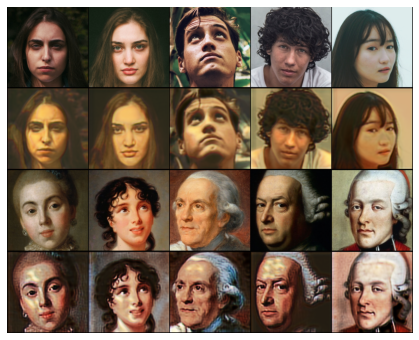

[Epoch 10/200]
[G loss: 2.737590789794922 | identity: 0.12704633176326752 GAN: 0.6987224817276001 cycle: 0.1403636634349823]
[D loss: 0.14723539352416992 | D_A: 0.09748859703540802 D_B: 0.19698220491409302]
----------------
[Epoch 11/200: G loss: 3.2359042167663574 | D loss: 0.2317485511302948]
----------------
[Epoch 12/200: G loss: 2.9357900619506836 | D loss: 0.12857462465763092]
----------------
[Epoch 13/200: G loss: 2.7638626098632812 | D loss: 0.15940412878990173]
----------------
[Epoch 14/200: G loss: 2.192383050918579 | D loss: 0.16579732298851013]
----------------
[Epoch 15/200: G loss: 2.813262701034546 | D loss: 0.11876335740089417]
----------------
[Epoch 16/200: G loss: 2.8617045879364014 | D loss: 0.14027360081672668]
----------------
[Epoch 17/200: G loss: 3.0200297832489014 | D loss: 0.1318509578704834]
----------------
[Epoch 18/200: G loss: 3.6572792530059814 | D loss: 0.1243538036942482]
----------------
[Epoch 19/200: G loss: 2.7727530002593994 | D loss: 0.1816331

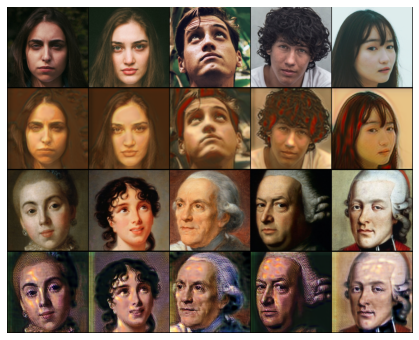

[Epoch 20/200]
[G loss: 2.790504217147827 | identity: 0.1411086916923523 GAN: 0.5931134819984436 cycle: 0.14918473362922668]
[D loss: 0.15240204334259033 | D_A: 0.1582358032464981 D_B: 0.14656829833984375]
----------------
[Epoch 21/200: G loss: 3.0405282974243164 | D loss: 0.1831410527229309]
----------------
[Epoch 22/200: G loss: 2.7621212005615234 | D loss: 0.16562390327453613]
----------------
[Epoch 23/200: G loss: 2.476804494857788 | D loss: 0.10221154987812042]
----------------
[Epoch 24/200: G loss: 3.1683082580566406 | D loss: 0.2020244151353836]
----------------
[Epoch 25/200: G loss: 2.3846404552459717 | D loss: 0.10994207113981247]
----------------
[Epoch 26/200: G loss: 2.4930691719055176 | D loss: 0.14481359720230103]
----------------
[Epoch 27/200: G loss: 2.739854574203491 | D loss: 0.17220404744148254]
----------------
[Epoch 28/200: G loss: 3.1751136779785156 | D loss: 0.3194977045059204]
----------------
[Epoch 29/200: G loss: 2.664741039276123 | D loss: 0.208441078

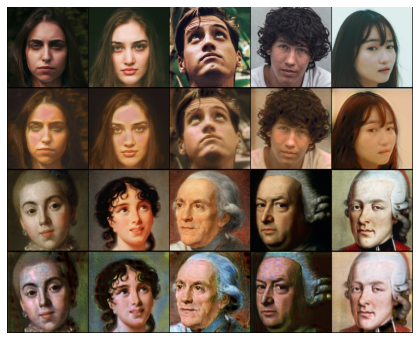

[Epoch 30/200]
[G loss: 2.764707565307617 | identity: 0.13501226902008057 GAN: 0.737580418586731 cycle: 0.13520656526088715]
[D loss: 0.14254271984100342 | D_A: 0.1445809006690979 D_B: 0.14050453901290894]
----------------
[Epoch 31/200: G loss: 2.6131439208984375 | D loss: 0.13441503047943115]
----------------
[Epoch 32/200: G loss: 2.7126822471618652 | D loss: 0.10126005858182907]
----------------
[Epoch 33/200: G loss: 2.5973830223083496 | D loss: 0.09073083847761154]
----------------
[Epoch 34/200: G loss: 2.5228025913238525 | D loss: 0.15723222494125366]
----------------
[Epoch 35/200: G loss: 2.607983112335205 | D loss: 0.15717235207557678]
----------------
[Epoch 36/200: G loss: 2.8794660568237305 | D loss: 0.16312859952449799]
----------------
[Epoch 37/200: G loss: 2.225579023361206 | D loss: 0.11193111538887024]
----------------
[Epoch 38/200: G loss: 2.73573899269104 | D loss: 0.15419936180114746]
----------------
[Epoch 39/200: G loss: 2.986116409301758 | D loss: 0.21186281

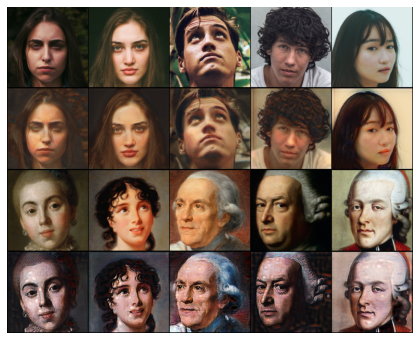

[Epoch 40/200]
[G loss: 2.5140221118927 | identity: 0.1292736977338791 GAN: 0.5371372699737549 cycle: 0.13305163383483887]
[D loss: 0.18125039339065552 | D_A: 0.2652745544910431 D_B: 0.09722621738910675]
----------------
[Epoch 41/200: G loss: 2.813922643661499 | D loss: 0.15790992975234985]
----------------
[Epoch 42/200: G loss: 2.5217020511627197 | D loss: 0.14768090844154358]
----------------
[Epoch 43/200: G loss: 2.515960216522217 | D loss: 0.10267085582017899]
----------------
[Epoch 44/200: G loss: 2.3605222702026367 | D loss: 0.1965099275112152]
----------------
[Epoch 45/200: G loss: 2.6797232627868652 | D loss: 0.09408840537071228]
----------------
[Epoch 46/200: G loss: 3.116273880004883 | D loss: 0.1356457769870758]
----------------
[Epoch 47/200: G loss: 2.527587413787842 | D loss: 0.09127427637577057]
----------------
[Epoch 48/200: G loss: 2.673591375350952 | D loss: 0.13900253176689148]
----------------
[Epoch 49/200: G loss: 2.6166293621063232 | D loss: 0.129861861467

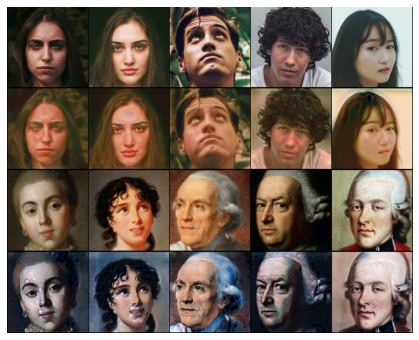

[Epoch 50/200]
[G loss: 2.5910253524780273 | identity: 0.13229569792747498 GAN: 0.4225066304206848 cycle: 0.150704026222229]
[D loss: 0.14154209196567535 | D_A: 0.1558784693479538 D_B: 0.1272057145833969]
----------------
[Epoch 51/200: G loss: 2.396432876586914 | D loss: 0.07985980808734894]
----------------
[Epoch 52/200: G loss: 2.2081267833709717 | D loss: 0.16727833449840546]
----------------
[Epoch 53/200: G loss: 2.4252564907073975 | D loss: 0.09207254648208618]
----------------
[Epoch 54/200: G loss: 2.290714979171753 | D loss: 0.10860815644264221]
----------------
[Epoch 55/200: G loss: 2.431265354156494 | D loss: 0.06739974021911621]
----------------
[Epoch 56/200: G loss: 3.00154972076416 | D loss: 0.2869057059288025]
----------------
[Epoch 57/200: G loss: 2.4915900230407715 | D loss: 0.1508236527442932]
----------------
[Epoch 58/200: G loss: 2.4074010848999023 | D loss: 0.19193702936172485]
----------------
[Epoch 59/200: G loss: 2.130333423614502 | D loss: 0.079780168831

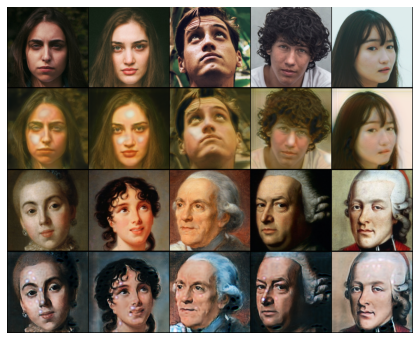

[Epoch 60/200]
[G loss: 2.536789655685425 | identity: 0.13021153211593628 GAN: 0.5226356983184814 cycle: 0.13630962371826172]
[D loss: 0.28199490904808044 | D_A: 0.3686816990375519 D_B: 0.1953081339597702]
----------------
[Epoch 61/200: G loss: 2.3534047603607178 | D loss: 0.15234357118606567]
----------------
[Epoch 62/200: G loss: 2.3451006412506104 | D loss: 0.14414048194885254]
----------------
[Epoch 63/200: G loss: 2.3219780921936035 | D loss: 0.19210213422775269]
----------------
[Epoch 64/200: G loss: 2.6100921630859375 | D loss: 0.2320701777935028]
----------------
[Epoch 65/200: G loss: 2.3543829917907715 | D loss: 0.14437341690063477]
----------------
[Epoch 66/200: G loss: 2.262599229812622 | D loss: 0.11328448355197906]
----------------
[Epoch 67/200: G loss: 1.9384524822235107 | D loss: 0.09971655160188675]
----------------
[Epoch 68/200: G loss: 2.196371078491211 | D loss: 0.15043503046035767]
----------------
[Epoch 69/200: G loss: 2.374168634414673 | D loss: 0.1671516

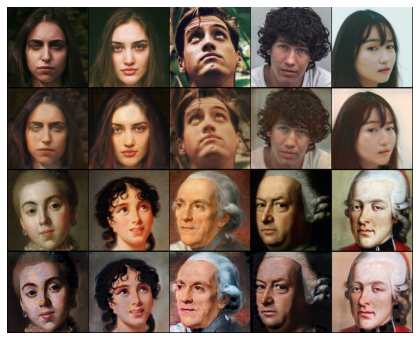

[Epoch 70/200]
[G loss: 2.565652370452881 | identity: 0.09751677513122559 GAN: 0.8488852977752686 cycle: 0.12291830778121948]
[D loss: 0.11726001650094986 | D_A: 0.07559552788734436 D_B: 0.15892450511455536]
----------------
[Epoch 71/200: G loss: 2.9487290382385254 | D loss: 0.199129119515419]
----------------
[Epoch 72/200: G loss: 2.1461572647094727 | D loss: 0.17359168827533722]
----------------
[Epoch 73/200: G loss: 1.8395655155181885 | D loss: 0.16332349181175232]
----------------
[Epoch 74/200: G loss: 2.659107208251953 | D loss: 0.14662815630435944]
----------------
[Epoch 75/200: G loss: 2.1640522480010986 | D loss: 0.12193311750888824]
----------------
[Epoch 76/200: G loss: 2.839254856109619 | D loss: 0.15672439336776733]
----------------
[Epoch 77/200: G loss: 2.2355175018310547 | D loss: 0.13032016158103943]
----------------
[Epoch 78/200: G loss: 2.065467357635498 | D loss: 0.1597132384777069]
----------------
[Epoch 79/200: G loss: 2.2014403343200684 | D loss: 0.1636412

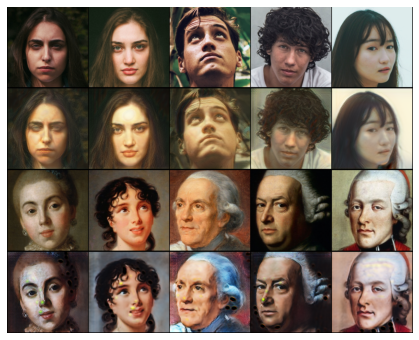

[Epoch 80/200]
[G loss: 2.425686836242676 | identity: 0.10611657798290253 GAN: 0.7199006080627441 cycle: 0.11752033978700638]
[D loss: 0.10804175585508347 | D_A: 0.07624100148677826 D_B: 0.13984251022338867]
----------------
[Epoch 81/200: G loss: 2.370709180831909 | D loss: 0.15244728326797485]
----------------
[Epoch 82/200: G loss: 2.1822428703308105 | D loss: 0.11923322081565857]
----------------
[Epoch 83/200: G loss: 2.8153867721557617 | D loss: 0.11385011672973633]
----------------
[Epoch 84/200: G loss: 2.133586883544922 | D loss: 0.11939163506031036]
----------------
[Epoch 85/200: G loss: 2.3625240325927734 | D loss: 0.11502406001091003]
----------------
[Epoch 86/200: G loss: 2.248821496963501 | D loss: 0.18581968545913696]
----------------
[Epoch 87/200: G loss: 2.1403064727783203 | D loss: 0.13261735439300537]
----------------
[Epoch 88/200: G loss: 1.9918270111083984 | D loss: 0.13677185773849487]
----------------
[Epoch 89/200: G loss: 2.227041721343994 | D loss: 0.13468

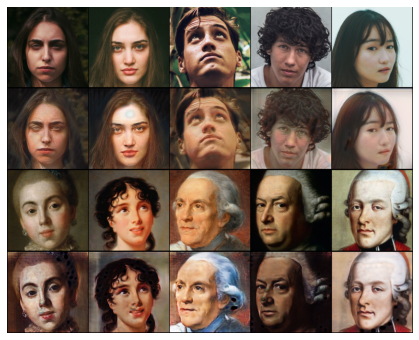

[Epoch 90/200]
[G loss: 2.2818329334259033 | identity: 0.10981960594654083 GAN: 0.4166768789291382 cycle: 0.13160580396652222]
[D loss: 0.17737965285778046 | D_A: 0.20910730957984924 D_B: 0.14565199613571167]
----------------
[Epoch 91/200: G loss: 2.1785407066345215 | D loss: 0.14724785089492798]
----------------
[Epoch 92/200: G loss: 2.2999610900878906 | D loss: 0.1242254376411438]
----------------
[Epoch 93/200: G loss: 2.4332027435302734 | D loss: 0.0961984321475029]
----------------
[Epoch 94/200: G loss: 2.527698040008545 | D loss: 0.11620041728019714]
----------------
[Epoch 95/200: G loss: 2.5987632274627686 | D loss: 0.08046240359544754]
----------------
[Epoch 96/200: G loss: 2.554058074951172 | D loss: 0.13522952795028687]
----------------
[Epoch 97/200: G loss: 2.2485198974609375 | D loss: 0.15275725722312927]
----------------
[Epoch 98/200: G loss: 2.1509644985198975 | D loss: 0.11888619512319565]
----------------
[Epoch 99/200: G loss: 2.0960330963134766 | D loss: 0.1293

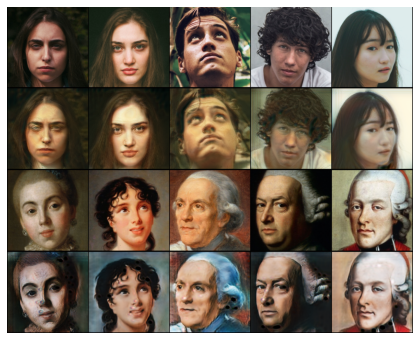

[Epoch 100/200]
[G loss: 2.3475289344787598 | identity: 0.10653640329837799 GAN: 0.6214946508407593 cycle: 0.11933521926403046]
[D loss: 0.16136899590492249 | D_A: 0.18450987339019775 D_B: 0.13822811841964722]
----------------
[Epoch 101/200: G loss: 2.6095213890075684 | D loss: 0.12964162230491638]
----------------
[Epoch 102/200: G loss: 2.131338119506836 | D loss: 0.11677993088960648]
----------------
[Epoch 103/200: G loss: 2.1303248405456543 | D loss: 0.1012105643749237]
----------------
[Epoch 104/200: G loss: 2.2009973526000977 | D loss: 0.14305825531482697]
----------------
[Epoch 105/200: G loss: 2.274146556854248 | D loss: 0.18594121932983398]
----------------
[Epoch 106/200: G loss: 2.1454849243164062 | D loss: 0.1141572818160057]
----------------
[Epoch 107/200: G loss: 1.9447834491729736 | D loss: 0.12860941886901855]
----------------
[Epoch 108/200: G loss: 2.0517959594726562 | D loss: 0.13745182752609253]
----------------
[Epoch 109/200: G loss: 2.344135046005249 | D los

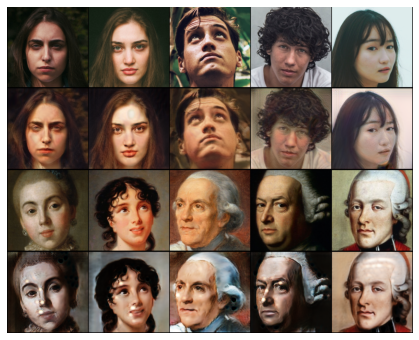

[Epoch 110/200]
[G loss: 2.0297529697418213 | identity: 0.08347438275814056 GAN: 0.5796931982040405 cycle: 0.10326879471540451]
[D loss: 0.10817109048366547 | D_A: 0.1037413626909256 D_B: 0.11260081082582474]
----------------
[Epoch 111/200: G loss: 2.031172513961792 | D loss: 0.08367294073104858]
----------------
[Epoch 112/200: G loss: 2.3704144954681396 | D loss: 0.07144252210855484]
----------------
[Epoch 113/200: G loss: 2.367565155029297 | D loss: 0.10163876414299011]
----------------
[Epoch 114/200: G loss: 2.130709409713745 | D loss: 0.1997716724872589]
----------------
[Epoch 115/200: G loss: 1.7228987216949463 | D loss: 0.11621136963367462]
----------------
[Epoch 116/200: G loss: 2.2668910026550293 | D loss: 0.1309448480606079]
----------------
[Epoch 117/200: G loss: 2.1068644523620605 | D loss: 0.17618227005004883]
----------------
[Epoch 118/200: G loss: 2.1410586833953857 | D loss: 0.1316719800233841]
----------------
[Epoch 119/200: G loss: 2.1509602069854736 | D loss:

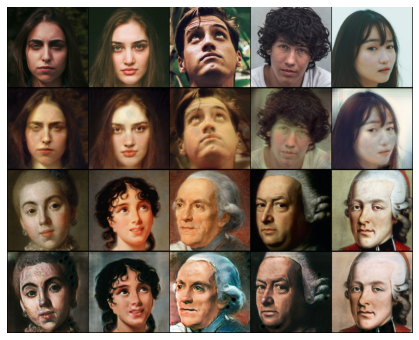

[Epoch 120/200]
[G loss: 1.8628129959106445 | identity: 0.08903571963310242 GAN: 0.4048965573310852 cycle: 0.1012737900018692]
[D loss: 0.1577349603176117 | D_A: 0.12064206600189209 D_B: 0.1948278695344925]
----------------
[Epoch 121/200: G loss: 1.6341484785079956 | D loss: 0.13128310441970825]
----------------
[Epoch 122/200: G loss: 2.200188159942627 | D loss: 0.128977969288826]
----------------
[Epoch 123/200: G loss: 1.9774423837661743 | D loss: 0.12795889377593994]
----------------
[Epoch 124/200: G loss: 1.7431485652923584 | D loss: 0.1100970059633255]
----------------
[Epoch 125/200: G loss: 2.091295003890991 | D loss: 0.08640164136886597]
----------------
[Epoch 126/200: G loss: 1.9711730480194092 | D loss: 0.12532952427864075]
----------------
[Epoch 127/200: G loss: 1.8636542558670044 | D loss: 0.09202718734741211]
----------------
[Epoch 128/200: G loss: 2.1486167907714844 | D loss: 0.0837300643324852]
----------------
[Epoch 129/200: G loss: 2.0578298568725586 | D loss: 0

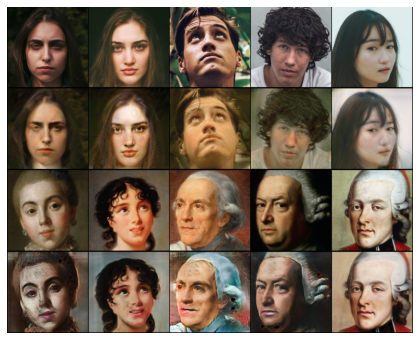

[Epoch 130/200]
[G loss: 1.8053544759750366 | identity: 0.07553378492593765 GAN: 0.48955684900283813 cycle: 0.09381286799907684]
[D loss: 0.11471444368362427 | D_A: 0.13390392065048218 D_B: 0.09552495926618576]
----------------
[Epoch 131/200: G loss: 2.232790231704712 | D loss: 0.09603489935398102]
----------------
[Epoch 132/200: G loss: 2.0269644260406494 | D loss: 0.10599541664123535]
----------------
[Epoch 133/200: G loss: 2.1525044441223145 | D loss: 0.08243192732334137]
----------------
[Epoch 134/200: G loss: 2.0595102310180664 | D loss: 0.10388819873332977]
----------------
[Epoch 135/200: G loss: 2.191452980041504 | D loss: 0.06918074190616608]
----------------
[Epoch 136/200: G loss: 1.9258404970169067 | D loss: 0.09613361954689026]
----------------
[Epoch 137/200: G loss: 1.9878696203231812 | D loss: 0.10822934657335281]
----------------
[Epoch 138/200: G loss: 1.8854504823684692 | D loss: 0.10197293758392334]
----------------
[Epoch 139/200: G loss: 2.0147318840026855 | D

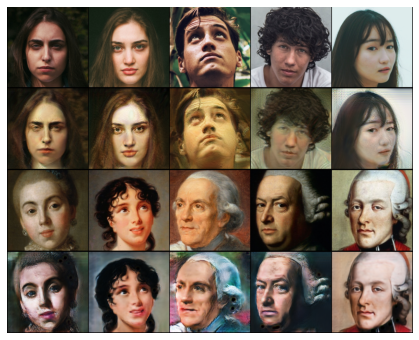

[Epoch 140/200]
[G loss: 1.841163158416748 | identity: 0.07589240372180939 GAN: 0.656927764415741 cycle: 0.08047732710838318]
[D loss: 0.12372864037752151 | D_A: 0.09257081151008606 D_B: 0.15488646924495697]
----------------
[Epoch 141/200: G loss: 1.9448497295379639 | D loss: 0.08437113463878632]
----------------
[Epoch 142/200: G loss: 1.838423490524292 | D loss: 0.08676613867282867]
----------------
[Epoch 143/200: G loss: 1.977333903312683 | D loss: 0.09005945920944214]
----------------
[Epoch 144/200: G loss: 1.9594569206237793 | D loss: 0.11461842060089111]
----------------
[Epoch 145/200: G loss: 2.0684242248535156 | D loss: 0.13188590109348297]
----------------
[Epoch 146/200: G loss: 1.8443176746368408 | D loss: 0.10711827129125595]
----------------
[Epoch 147/200: G loss: 2.049406051635742 | D loss: 0.10030385851860046]
----------------
[Epoch 148/200: G loss: 1.9915447235107422 | D loss: 0.09714513272047043]
----------------
[Epoch 149/200: G loss: 2.0147294998168945 | D los

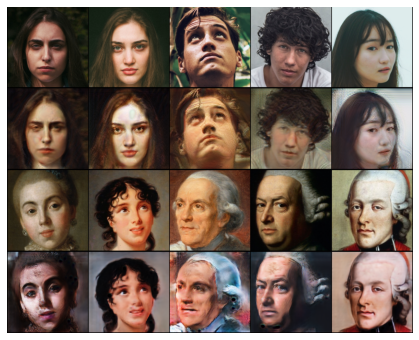

[Epoch 150/200]
[G loss: 1.8930621147155762 | identity: 0.06300105154514313 GAN: 0.7342712879180908 cycle: 0.08437855541706085]
[D loss: 0.06932950019836426 | D_A: 0.07270900905132294 D_B: 0.06594999134540558]
----------------
[Epoch 151/200: G loss: 1.8295882940292358 | D loss: 0.09062851220369339]
----------------
[Epoch 152/200: G loss: 1.8737787008285522 | D loss: 0.08914779126644135]
----------------
[Epoch 153/200: G loss: 1.8399099111557007 | D loss: 0.09092080593109131]
----------------
[Epoch 154/200: G loss: 2.0623831748962402 | D loss: 0.0929819643497467]
----------------
[Epoch 155/200: G loss: 1.7774157524108887 | D loss: 0.08333756029605865]
----------------
[Epoch 156/200: G loss: 1.7301149368286133 | D loss: 0.05694233998656273]
----------------
[Epoch 157/200: G loss: 1.8265514373779297 | D loss: 0.09563843905925751]
----------------
[Epoch 158/200: G loss: 2.0193448066711426 | D loss: 0.09310874342918396]
----------------
[Epoch 159/200: G loss: 1.5737762451171875 | D

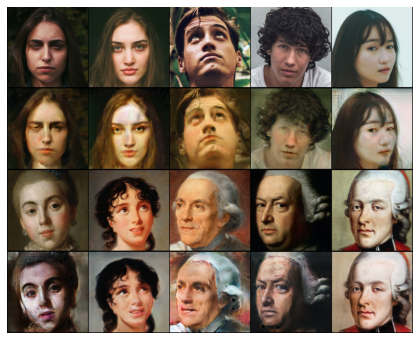

[Epoch 160/200]
[G loss: 2.0188448429107666 | identity: 0.07023255527019501 GAN: 0.7419693470001221 cycle: 0.09257126599550247]
[D loss: 0.12450220435857773 | D_A: 0.09106417000293732 D_B: 0.15794023871421814]
----------------
[Epoch 161/200: G loss: 2.081441640853882 | D loss: 0.0811692401766777]
----------------
[Epoch 162/200: G loss: 1.8860738277435303 | D loss: 0.0749455988407135]
----------------
[Epoch 163/200: G loss: 1.9734392166137695 | D loss: 0.07199250906705856]
----------------
[Epoch 164/200: G loss: 1.803787112236023 | D loss: 0.10199569165706635]
----------------
[Epoch 165/200: G loss: 1.7766835689544678 | D loss: 0.08461599051952362]
----------------
[Epoch 166/200: G loss: 2.0801119804382324 | D loss: 0.10262449085712433]
----------------
[Epoch 167/200: G loss: 1.886502742767334 | D loss: 0.08554691076278687]
----------------
[Epoch 168/200: G loss: 1.8574883937835693 | D loss: 0.07823218405246735]


In [ ]:
lossG = []
lossD = []
lossAdv = []
lossCycle = []
lossIde = []
for epoch in range(n_epoches):
    for i, (real_A, real_B) in enumerate(trainloader):
        # Set model input
        real_A = Variable(real_A.type(Tensor))
        real_B = Variable(real_B.type(Tensor))
        
        # Adversarial groud truth
        out_shape = [real_A.size(0), 1, real_A.size(2)//D_A.scale_factor, real_A.size(3)//D_A.scale_factor]
        valid = torch.ones(out_shape).type(Tensor)
        fake = torch.zeros(out_shape).type(Tensor)
        
        # ------------------
        #  Train Generators
        # ------------------
        G_AB.train()
        G_BA.train()
        
        optimizer_G.zero_grad()
        

        # Identity loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2
        
        # GAN loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) 
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        
        # Cycle loss
        recov_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        
        # Calculate the Generators total loss
        loss_G = 5.0*loss_identity + loss_GAN + 10.0*loss_cycle
        
        loss_G.backward()
        optimizer_G.step()
        
        # -----------------------
        #  Train Discriminator A
        # -----------------------
        optimizer_D_A.zero_grad()
        
        # Real loss
        loss_real = criterion_GAN(D_A(real_A), valid)
        
        # Fake loss (on batch of previously generated samples)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
        
        # Total loss
        loss_D_A = (loss_real + loss_fake) / 2
        
        loss_D_A.backward()
        optimizer_D_A.step()
        
        # -----------------------
        #  Train Discriminator B
        # -----------------------
        optimizer_D_B.zero_grad()

        # Real loss
        loss_real = criterion_GAN(D_B(real_B), valid)
                                             
        # Fake loss (on batch of previously generated samples)
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
                                             
        # Total loss
        loss_D_B = (loss_real + loss_fake) / 2
        
        loss_D_B.backward()
        optimizer_D_B.step()
        
        # Discriminator total loss                                     
        loss_D = (loss_D_A + loss_D_B) / 2
                                             
    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
    # Append losses
    lossG.append(float(loss_G.item()))
    lossD.append(float(loss_D.item()))
    lossAdv.append(float(loss_GAN.item()))
    lossCycle.append(float(loss_cycle.item()))
    lossIde.append(float(loss_identity.item()))
    # Print log
    if (epoch+1) % 10 != 0:
        print('----------------')
        print(f'[Epoch {epoch+1}/{n_epoches}: G loss: {loss_G.item()} | D loss: {loss_D.item()}]')
    # test
    if (epoch+1) % 10 == 0:
        print('----------------')
        test_real_A, test_real_B = next(iter(testloader))
        sample_images(test_real_A, test_real_B)  
        print(f'[Epoch {epoch+1}/{n_epoches}]')
        print(f'[G loss: {loss_G.item()} | identity: {loss_identity.item()} GAN: {loss_GAN.item()} cycle: {loss_cycle.item()}]')
        print(f'[D loss: {loss_D.item()} | D_A: {loss_D_A.item()} D_B: {loss_D_B.item()}]')

In [ ]:
import matplotlib.pyplot as plt

x = list(range(1, 201))
plt.plot(x,lossG, color = 'blue', label='Generator Loss')
plt.plot(x,lossD, color = 'red', label='Discriminator Loss')
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.show()

# Save test images

In [ ]:
photo_dir = os.path.join(data_dir, 'real_portraits')
files = [os.path.join(photo_dir, name) for name in os.listdir(photo_dir)]
len(files)

In [ ]:
save_dir = '../images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
generate_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

to_image = transforms.ToPILImage()

G_AB.eval()
for i in range(0, len(files), batch_size):
    # read images
    imgs = []
    for j in range(i, min(len(files), i+batch_size)):
        img = Image.open(files[j])
        img = generate_transforms(img)
        imgs.append(img)
    imgs = torch.stack(imgs, 0).type(Tensor)
    
    # generate
    fake_imgs = G_AB(imgs).detach().cpu()
    
    # save
    for j in range(fake_imgs.size(0)):
        img = fake_imgs[j].squeeze().permute(1, 2, 0)
        img_arr = img.numpy()
        img_arr = (img_arr - np.min(img_arr)) * 255 / (np.max(img_arr) - np.min(img_arr))
        img_arr = img_arr.astype(np.uint8)
        
        img = to_image(img_arr)
        _, name = os.path.split(files[i+j])
        img.save(os.path.join(save_dir, name))

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")